In [4]:
# A module to implement the gradient descent learning algorithm for a feedforward neural network.

import random
import numpy as np

class Network(object):
    
    # the list ''sizes'' contains the number of neurons in the respective layers of the network.
    # [2, 3, 1] input layer 2 neurons, hidden layer 3 neurons, output layer 1 neuron
    def __init__(self, sizes):

        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
       
    # return the output of the network if "a" is input.
    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a
    
    # “training_data” is a list of tuples "(x,y)" representing the training inputs and the desired outputs.
    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):

        training_data = list(training_data)
        n = len(training_data)
        
        if test_data:
            test_data = list(test_data)
            n_test = len(test_data)
            
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                print("Epoch {} : {} / {}".format(j,self.evaluate(test_data),n_test));
            else:
                print("Epoch {} complete".format(j))
                
    # update the network's weights and biases by applying gradient descent 
    # using backpropagation to a single mini batch.
    # The ''mini_batch'' is a list of tuples "(x,y)", and "eta" is the learning rate.
    def update_mini_batch(self, mini_batch, eta):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                       for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]
        
    # return a tuple "(nabla_b, nabla_w)" representing the gradient for the cost function.
    # "nabla_b" and "nabla_w" are layer-by-layer lists of numpy arrays.
    def backprop(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) #* \
  #          sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # l=1 means the last layer of the neurons
        # l=2 means the second-last layer
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)
    
    # the neural network's output is assumed to be the index of 
    # whichever neuron in the final layer has the highest activation.
    def evaluate(self, test_data):
        test_results = [(np.argmax(self.feedforward(x)),y)
                       for (x,y) in test_data]
        return sum(int(x == y) for (x,y) in test_results)
    
    # vector of partial derivatives \partial C_X / \partial a for the output activations.
    def cost_derivative(self, output_activations, y):
        return (output_activations-y)
    
# Miscellaneous functions
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))
    
def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

In [40]:
# A library to load the MNIST image data.
import pickle
import gzip
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# Return the MNIST data as a tuple containing the training data, the validation data, and the test data.
# The "training_data" is returned as a tuple with two entries.

# The first entry contains the actual training images. This is a numpy ndarray with 50,000 entries. Each entry is, 
# in turn, a numpy ndarray with 784 values, representing the 28 * 28 = 784 pixels in a single MNIST image.

# The second entry in the "training_data" tuple is a numpy ndarray containing 50,000 entries. Those entries
# are just the digit values (0,1,...,9) for the corresponding images contained in the first entry of the tuple.

# The "validation_data" and "test_data" are similar, except each contains only 10,000 images.
def load_data():

        f = gzip.open('mnist.pkl.gz','rb')
        training_data, validation_data, test_data = pickle.load(f, encoding="latin1")
        f.close()
        return (training_data, validation_data, test_data)

# Return a tuple containing "(training_data, validation_data, test_data)".
# "training_data" is a list containing 50,000 2-tuples "(x,y)". 
# "x" is a 784-dimensional numpy.ndarray containing the input image.
# "y" is a 10-dimensional numpy.ndarray representing the unit vector 
# corresponding to the correct digit for "x".
# "validation_data" and "test_data" are lists containing 10,000 2-tuples "(x,y)". In each case,
# "x" is a 784-dimensional numpy.ndarray containing the input image, and
# "y" is the corresponding classification, i.e., the digit values (integers) corresponding to "x".
def load_data_wrapper():
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784,1)) for x in tr_d[0]]
    
    plt.imshow(training_inputs[9].reshape((28,28)),cmap=cm.Greys_r)
    plt.show()
    
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = zip(training_inputs, training_results)
    validation_inputs = [np.reshape(x, (784,1)) for x in va_d[0]]
    validation_data = zip(validation_inputs, va_d[1])
    test_inputs = [np.reshape(x, (784,1)) for x in te_d[0]]
    test_data = zip(test_inputs, te_d[1])
    return (training_data, validation_data, test_data)

# Return a 10-dimensional unit vector with a 1.0 in the jth position and zeros elsewhere.
# This is used to convert a digit (0...9) into a corresponding desired output from the neural network.
def vectorized_result(j):
    e = np.zeros((10,1))
    e[j] = 1.0
    return e    

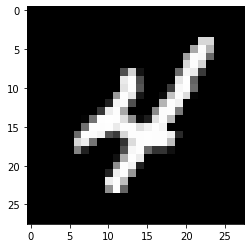

In [41]:
training_data, validation_data, test_data = load_data_wrapper()


In [27]:
net = Network([784,100,10])

In [31]:
net.SGD(training_data, 30, 10000, 3.0, test_data=test_data)     

Epoch 0 : 9656 / 10000
Epoch 1 : 9661 / 10000
Epoch 2 : 9662 / 10000
Epoch 3 : 9664 / 10000
Epoch 4 : 9667 / 10000
Epoch 5 : 9667 / 10000
Epoch 6 : 9667 / 10000
Epoch 7 : 9668 / 10000
Epoch 8 : 9667 / 10000
Epoch 9 : 9669 / 10000
Epoch 10 : 9668 / 10000
Epoch 11 : 9668 / 10000
Epoch 12 : 9668 / 10000
Epoch 13 : 9669 / 10000
Epoch 14 : 9668 / 10000
Epoch 15 : 9669 / 10000
Epoch 16 : 9668 / 10000
Epoch 17 : 9667 / 10000
Epoch 18 : 9670 / 10000
Epoch 19 : 9670 / 10000
Epoch 20 : 9669 / 10000
Epoch 21 : 9668 / 10000
Epoch 22 : 9669 / 10000
Epoch 23 : 9669 / 10000
Epoch 24 : 9670 / 10000
Epoch 25 : 9670 / 10000
Epoch 26 : 9669 / 10000
Epoch 27 : 9669 / 10000
Epoch 28 : 9671 / 10000
Epoch 29 : 9671 / 10000
